In [448]:
import matplotlib.pyplot as plt
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
import warnings

warnings.filterwarnings('ignore')

rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('Rssa')
rssa = importr('Rssa')

R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



In [748]:
def estimate_freq(series, L, outputs=False):
    frequency = None
    ssa = rssa.ssa(robjects.FloatVector(series), L=L, neig=min(2 * r, 50), svd_method='svd')
    groups = autogrouping(ssa, nclust=3, groups=robjects.r('''1:10'''), method="complete")
    g_form = ""
    for group in groups:
        g_form += "c(" + ''.join(str(list(group)))[1:-1] + '), '
    g_form = g_form[:-2]

    groups_est = rssa.parestimate(ssa, groups=robjects.r(f'list({g_form})'))
    for i, g_est in enumerate(groups_est):
        # estimate rates
        if outputs:
            print(g_est)
        # if len(g_est[1]) % 2 == 0:
        periods = {}
        max_period = 0
        number = -1
        for num, (period, mod) in enumerate(zip(g_est[1], g_est[-2])):
            # print(np.round(mod, 2))
            period = np.abs(period)
            if period != np.inf and np.round(mod, 1) == 1:
                if periods.get(np.round(period, 5)) is not None:
                    periods[np.round(period, 5)] += 1
                    if periods[np.round(period, 5)] == 2 and max_period < np.round(period, 5) < len(series):
                        max_period = np.round(period, 5)
                        number = num
                else:
                    periods[np.round(np.abs(period), 5)] = 1
        # print(periods)
        if number == -1:
            continue
        estimated_freq = np.abs(np.round(g_est[2][number], 3))
        if estimated_freq == 0:
            continue
        if outputs:
            print(f"Estimated frequency is {estimated_freq}")
        frequency = estimated_freq
        break
    if frequency is None and outputs:
        print("Cant estimate initial frequency!")
    return frequency

R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



   period     rate   |    Mod     Arg  |     Re        Im
      Inf   0.000232 |  1.00023   0.00 |  1.00023   0.00000
      Inf  -0.000245 |  0.99975   0.00 |  0.99975   0.00000

   period     rate   |    Mod     Arg  |     Re        Im
   53.050  -0.000288 |  0.99971   0.12 |  0.99271   0.11813
  -53.050  -0.000288 |  0.99971  -0.12 |  0.99271  -0.11813
      Inf  -2.742651 |  0.06440   0.00 |  0.06440   0.00000

Estimated frequency is 0.019


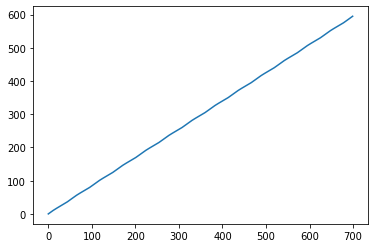

In [774]:
from utils.utils import generate_series

w1 = 1/53
Q = 301
N = 700
L = 60
r = 5

autogrouping = robjects.r('''
    install.packages("Rssa")
    library(Rssa)
    autogrouping = grouping.auto.wcor
''')

# series = generate_series(w1, w1, Q, N) + np.array([0.1*n for n in range(N)])
series = generate_series(w1, w1, Q, N) + np.array([0.85*n for n in range(N)])
plt.plot(series)

w1_est = estimate_freq(series, 80, True)

In [777]:
def test_freq_est(w1, Q, N, denom=None, eps=0.01, sigma=0):
    for mult in np.arange(0, 0.51, 0.01):

        series = generate_series(w1, w1, Q, N) + np.array([round(mult, 3)*n for n in range(N)]) + np.random.normal(scale=sigma, size=N)
        w1_est = estimate_freq(series, L)
        if w1_est is None:
            print(mult)
            estimate_freq(series, L, True)
        if np.abs(w1_est - w1) > eps:
            print(f"error in multiplier {mult}, w1_est is {w1_est}, w1 is {w1} | denom is {denom} | sigma is {sigma}")
            # return None
    return f"Passed: w1 is {w1}, w3_est is {w1_est}"

In [778]:
%%time
for sigma in np.arange(0, 0.8, 0.1):
    for denom in range(3, 100):
        freq = np.round(1/denom, 5)
        status = test_freq_est(freq, Q, N, denom, sigma=sigma)
        if status is None:
            print(f"Error: denom is {denom}")
        # print(f"Passed with denom {denom}: {status}")

error in multiplier 0.31, w1_est is 0.188, w1 is 0.2 | denom is 5 | sigma is 0.1
error in multiplier 0.49, w1_est is 0.102, w1 is 0.125 | denom is 8 | sigma is 0.1
error in multiplier 0.15, w1_est is 0.064, w1 is 0.07692 | denom is 13 | sigma is 0.1
error in multiplier 0.32, w1_est is 0.059, w1 is 0.07692 | denom is 13 | sigma is 0.1
error in multiplier 0.41000000000000003, w1_est is 0.043, w1 is 0.05882 | denom is 17 | sigma is 0.1
error in multiplier 0.08, w1_est is 0.024, w1 is 0.03846 | denom is 26 | sigma is 0.1
error in multiplier 0.2, w1_est is 0.002, w1 is 0.02941 | denom is 34 | sigma is 0.1
error in multiplier 0.46, w1_est is 0.301, w1 is 0.33333 | denom is 3 | sigma is 0.2
error in multiplier 0.11, w1_est is 0.177, w1 is 0.25 | denom is 4 | sigma is 0.2
error in multiplier 0.13, w1_est is 0.169, w1 is 0.2 | denom is 5 | sigma is 0.2
error in multiplier 0.02, w1_est is 0.147, w1 is 0.16667 | denom is 6 | sigma is 0.2
error in multiplier 0.47000000000000003, w1_est is 0.153, w